<a href="https://colab.research.google.com/github/Anteii/HPC-Labs/blob/main/lab2/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

In [1]:
from IPython.display import clear_output

In [2]:
#!apt-get --purge remove cuda nvidia* libnvidia-*
#!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
#!apt-get remove cuda-*
#!apt autoremove
#!apt-get update

#clear_output()

In [3]:
#!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
#!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
#!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
#!apt-get update
#!apt-get install cuda-9.2

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [5]:
!nvidia-smi

Mon Oct 17 21:03:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
clear_output()

In [7]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def readData(paramNames, classes):
  params = dict()

  for ind, name in enumerate(paramNames):
    with open(f"{name}.txt", "r") as f:
      params[name] = np.array(list(map(classes[ind], f.readline().split())))

  return params


# Vector reduction

In [ ]:
%%cu
#include <iostream>
#include <ctime>
#include <fstream>
#include <cassert>

using namespace std;

template<typename T>
void serializeArr(T* arr, int N, const string& paramName){
  ofstream myfile (paramName + ".txt");
  if (myfile.is_open())
  {
    for(int i = 0; i < N; ++i){
        myfile << arr[i] << " ";
    }
    myfile.close();
  }
  else cout << "Unable to open file";
}

void checkError(cudaError_t error){
	if (error != cudaSuccess){
		cout << "Error" << endl;
		cerr << cudaGetErrorString(error) << endl;
		exit(1);
	}
}

template<int blockSize, typename T_in, typename T_out>
__global__ void reduceVecKernel(const T_in* inArr, int N, T_out* buff) {
    int tid = threadIdx.x;
    int i = blockIdx.x * blockSize + tid;
    
    const int gridSize = blockSize * gridDim.x;

    T_out sum = 0;

    for (int j = i; j < N; j += gridSize){        
        sum += inArr[j];
    }

    __shared__ T_out sdata[blockSize];

    sdata[tid] = sum;

    __syncthreads();

    for (int s = blockSize/2; s > 0; s >>= 1) {
        if (tid < s)
            sdata[tid] += sdata[tid + s];
        __syncthreads();
    }

    if (tid == 0)
        buff[blockIdx.x] = sdata[0];
}

template<int blockSize, int gridSize>
__host__ float reduceVecGpu(int* arr, const int N, long* result) {
    
    int* arr_dev;
    long* buff_dev;
  
    int arr_type_size = sizeof(int);
    int buff_type_size = sizeof(long);

    int arr_size = N * arr_type_size; 
    int buff_size = blockSize * buff_type_size;

    float totalTime;
	  cudaEvent_t startEvent, stopEvent;

    checkError(cudaEventCreate(&startEvent));
	  checkError(cudaEventCreate(&stopEvent));

    checkError(cudaMalloc(&arr_dev, arr_size));
    checkError(cudaMemcpy(arr_dev, arr, arr_size, cudaMemcpyHostToDevice));

    checkError(cudaMalloc(&buff_dev, buff_size));
    checkError(cudaMemset(buff_dev, 0, buff_size));
    
    checkError(cudaEventRecord(startEvent, 0));

    // Reduction by blocks
    reduceVecKernel<blockSize, int, long><<<gridSize, blockSize>>>(arr_dev, N, buff_dev);
    
    checkError(cudaEventRecord(stopEvent, 0));
    
    // Reduction with intermediate results
    reduceVecKernel<blockSize, long, long><<<1, blockSize>>>(buff_dev, gridSize, buff_dev);

    checkError(cudaDeviceSynchronize());
    
    checkError(cudaEventElapsedTime(&totalTime, startEvent, stopEvent));
    
    checkError(cudaMemcpy(result, buff_dev, 1 * buff_type_size, cudaMemcpyDeviceToHost));
    
    cudaFree(arr_dev);
    cudaFree(buff_dev);
    
    return totalTime / 1000;
}

float reduceVecCpu(int* vec, int N, long* cumSum){
    
    long cumSumLoc = 0;
    clock_t start, end;

    start = clock();

    for (int i = 0; i < N; ++i){
        cumSumLoc += vec[i];
    }

    end = clock();

    *cumSum = cumSumLoc;

    return 1.0f * (end - start) / CLOCKS_PER_SEC;
}

void randomFill(int* vec, int N, 
                float scale = 1, float bias = 0){
    for (int i = 0; i < N; ++i){
        vec[i] = scale * rand() / RAND_MAX + bias;
    }
}

void printVec(int* vec, int N){
    cout << "[ "; 
    for (int i = 0; i < N; ++i){
        cout << vec[i] << (i == N-1 ? "": ", ");
    }
    cout << "]" << endl;
}

void experiment(int N, int repeats,
                float* cpuTime, float* gpuTime){
    
    *cpuTime = 0;
    *gpuTime = 0;

    int* vec = (int*)malloc(N * sizeof(int));
    long cumSumCpu = 0;
    long cumSumGpu = 0;

    for (int repeat = 0; repeat < repeats; ++repeat){
        randomFill(vec, N, 10000, 0);

        *cpuTime += reduceVecCpu(vec, N, &cumSumCpu);
        *gpuTime += reduceVecGpu<1024, 32>(vec, N, &cumSumGpu);
        
        assert( cumSumCpu == cumSumGpu );
    }
    
    *cpuTime /= repeats;
    *gpuTime /= repeats;

    // cout << "CPU Time: " << *cpuTime << endl;
    // cout << "GPU Time: " << *gpuTime << endl;
    
    free(vec);
}

int main(){
    
    srand(42);
 
    int expNum = 100;
    int nRuns = 5;

    int* paramN = (int*)malloc(expNum * sizeof(int));
 
    float* paramCpuTime = (float*)malloc(expNum * sizeof(float));
    float* paramGpuTime = (float*)malloc(expNum * sizeof(float));


    for (int i = 0; i < expNum; ++i){
        
        paramN[i] = int(1000000 * 1.0f * rand() / RAND_MAX) + 1000;
        //paramN[i] = 523250 + i;
        //cout << "N = " << paramN[i] << endl;
        experiment(paramN[i], nRuns,
                  paramCpuTime + i, paramGpuTime + i);
    }

    // For easy conversion to python
    
    serializeArr<int>(paramN, expNum, "N");
    serializeArr<float>(paramCpuTime, expNum, "cpuTime");
    serializeArr<float>(paramGpuTime, expNum, "gpuTime");

    free(paramN);
    free(paramCpuTime);
    free(paramGpuTime);

    return 0;
}

# Visualization

Про выбор конфигурации сетки
https://events.prace-ri.eu/event/477/sessions/1420/attachments/391/580/CUDA_MM.pdf

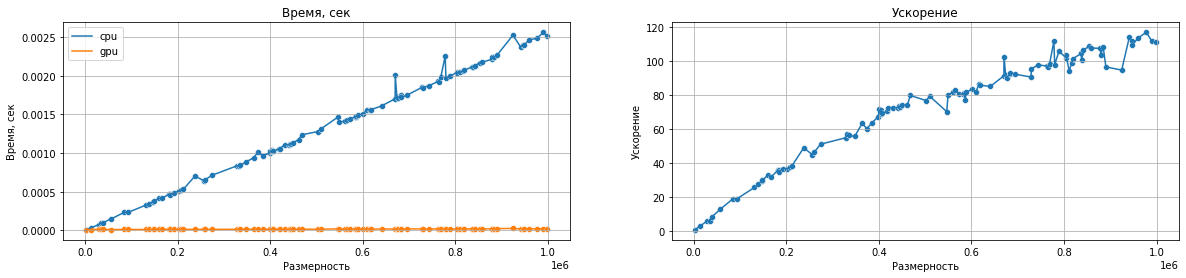

In [142]:
params = readData(["N", "cpuTime", "gpuTime"], [int, float, float])

sorted_data = sorted(np.transpose(list(params.values())).tolist(), key=lambda x:x[0])
N, cpu_time, gpu_time = np.transpose(sorted_data)
speed_up = cpu_time / gpu_time

expNum = len(N)

fig, axs = plt.subplots(ncols=2, figsize=(20, 4))

axs[0].set_title("Время, сек")
axs[0].set_xlabel("Размерность")
axs[0].set_ylabel("Время, сек")
axs[0].grid()
sns.scatterplot(x=N, y=cpu_time, ax=axs[0])
sns.scatterplot(x=N, y=gpu_time, ax=axs[0])
sns.lineplot(x=N, y=cpu_time, ax=axs[0], label="cpu")
sns.lineplot(x=N, y=gpu_time, ax=axs[0], label="gpu")

axs[1].set_title("Ускорение")
axs[1].set_xlabel("Размерность")
axs[1].set_ylabel("Ускорение")
axs[1].grid()

sns.scatterplot(x=N, y=speed_up, ax=axs[1])
sns.lineplot(x=N, y=speed_up, ax=axs[1]);

При размере блока 512, начиная с 523265 элемента идет просадка ускорения, при 1024 этого нет, размер лонга в куде - 8 байт.